# Glove Embedding Visualization of Textually Similar and Textually Dissimilar Duplicate Bug Reports

Installing the gensim package

In [ ]:
!pip install gensim

In [ ]:
import pickle
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

Downloading pretrained GloVe

In [ ]:
glove_file = datapath('/content/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.txt")

In [ ]:
 !wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
 !unzip glove*.zip

In [ ]:
import numpy as np
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
import pickle
pickle.dump({'embeddings_index' : embeddings_index } , open('/content/glove.6B.100d.txt', 'wb'))

In [ ]:
from typing import List

In [ ]:
MAX_TOKENS = 100
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 350
EMBEDDING_DIM = 100

Function for building a vocabulary

In [ ]:
def build_vocab(sentences: List[str], sequence_length: int):
  vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS - 2,
    output_sequence_length=sequence_length,
  )
  vectorizer.adapt(sentences)
  vocab = vectorizer.get_vocabulary()
  word_index = dict(zip(vocab, range(len(vocab))))

  return vectorizer, word_index

In [ ]:
from keras.layers.preprocessing.text_vectorization import TextVectorization

In [ ]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# **ECLIPSE**

# Textually Similar

In [ ]:
df_sim1 = pd.read_csv("drive/MyDrive/Project 6308 + ICSME/Dataset Pre-processing_Siamese/Dataset for Siamese model /Eclipse_siamese_textually_similar_test_duplicates_preprocessed.csv")
df_sim = df_sim1[df_sim1['is_similar'] > 0]
df_sim = df_sim.sample(n=100, random_state=1).reset_index(drop=True)
df_sim.loc[df_sim["is_similar"] == 1, "Textual_Similarity"] = "Textually Similar"
df_sim

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,222,since some time i can t use mylyn reviews an...,support gerrit documentation storage ...,1,Textually Similar
1,270,extracted from bug example see bug tr...,the launch configuration validation returns ...,1,Textually Similar
2,30,created attachment simple jframe program o...,created attachment screenshot hi i recei...,1,Textually Similar
3,501,i used standard search to find text in java ...,created attachment thread access error ec...,1,Textually Similar
4,484,this bug appeared since i upgraded to macos ...,since the upgrade on macsos sierra i have s...,1,Textually Similar
...,...,...,...,...,...
95,502,links to projects appear to be broken ...,if today i go to and click e g on the ve...,1,Textually Similar
96,429,created attachment pom file with dependenc...,hi all this is not a new thing but it is pr...,1,Textually Similar
97,538,what steps will reproduce the problem g...,not sure what i did but while editing a ja...,1,Textually Similar
98,493,using jee photon linux gtk tar gz i...,bug comment the warning builtin lfs su...,1,Textually Similar


In [ ]:
MAX_TOKENS = 100
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 300
EMBEDDING_DIM = 100

In [ ]:
#Building a vocab and creating a word embedding of the descriptions

descr_vectorizer, descr_word_index = build_vocab(
  [df_sim.description1, df_sim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'eclipse', 'org', 'at']


In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (100, 100)
Found 91 words, missed 7.


In [ ]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.44308999,  0.14926   ,  0.16649   , ...,  0.044676  ,
         0.139     , -0.10406   ],
       ...,
       [-0.56541002, -0.42594999, -0.077894  , ..., -0.88941002,
         0.11422   ,  0.60136998],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 100 points as TSNE takes a lot of time for 15K points
data_100 = descr_embedding_matrix
# labels_100 = df_dissim.is_similar

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=7000,metric='cosine')
# configuring the parameteres

tsne_data = model.fit_transform(data_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [ ]:
sim_label = df_sim["Textual_Similarity"]

In [ ]:
tsne_data = np.vstack((tsne_data.T, sim_label)).T
tsne_df_sim = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Textual_Similarity"))

In [ ]:
tsne_df_sim

,Dim_1,Dim_2,Textual_Similarity
0,0.530456,0.103133,Textually Similar
1,11.778447,-2.712877,Textually Similar
2,11.394832,8.080999,Textually Similar
3,6.52169,4.317415,Textually Similar
4,10.110093,9.918163,Textually Similar
...,...,...,...
95,9.50361,9.05796,Textually Similar
96,6.84813,4.135288,Textually Similar
97,7.119141,5.336359,Textually Similar
98,6.293101,-1.015972,Textually Similar


# Textually Dissimilar

In [ ]:
df_dissim1 = pd.read_csv("drive/MyDrive/Project 6308 + ICSME/Dataset Pre-processing_Siamese/Dataset for Siamese model /Eclipse_siamese_textually_dissimilar_test_duplicates_preprocessed.csv")
df_dissim = df_dissim1[df_dissim1['is_similar'] > 0]
df_dissim = df_dissim.sample(n=100, random_state=1).reset_index(drop=True)
df_dissim.loc[df_dissim["is_similar"] == 1, "Textual_Similarity"] = "Textually Dissimilar"
df_dissim

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,381,starting from java the module system was...,starting from java the module system was...,1,Textually Dissimilar
1,375,with jdt s async content assist enabled the...,change javasourceviewerconfiguratio...,1,Textually Dissimilar
2,582,created attachment shows the white backgro...,please try a simple swt snippet like publi...,1,Textually Dissimilar
3,443,minimal example struct a std vector...,since version the eclipse parser retur...,1,Textually Dissimilar
4,424,one of the following junit tests fail cla...,when converting lambda expression to method ...,1,Textually Dissimilar
...,...,...,...,...,...
95,94,i never change the default settings on the e...,we should add the option to skip the branch ...,1,Textually Dissimilar
96,523,i open an editor a language server is being...,the inlined annotation draw process is don...,1,Textually Dissimilar
97,294,created attachment git hooks commit msg c...,created attachment git hooks commit msg c...,1,Textually Dissimilar
98,293,editor shows no return in function returnin...,for this function template typename t v...,1,Textually Dissimilar


In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [df_dissim.description1, df_dissim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'in', 'gtk', 'the']


In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (100, 100)
Found 91 words, missed 7.


In [ ]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.085703  , -0.22201   ,  0.16569   , ..., -0.074273  ,
         0.75808001, -0.34243   ],
       ...,
       [ 1.06389999, -0.36480999, -0.34184   , ...,  0.39166999,
         0.87564999, -0.55912   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 100 points as TSNE takes a lot of time for 15K points
data_100 = descr_embedding_matrix
# labels_100 = df_dissim.is_similar

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=7000,metric='cosine')
# configuring the parameteres

tsne_data = model.fit_transform(data_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [ ]:
sim_label = df_dissim["Textual_Similarity"]

In [ ]:
tsne_data = np.vstack((tsne_data.T, sim_label)).T
tsne_df_dissim = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Textual_Similarity"))

Concatenating both the tsne tables for textually similar and dissimilar

In [ ]:
complete_tsne_df = pd.concat([tsne_df_sim, tsne_df_dissim], ignore_index=True)
complete_tsne_df

,Dim_1,Dim_2,Textual_Similarity
0,0.530456,0.103133,Textually Similar
1,11.778447,-2.712877,Textually Similar
2,11.394832,8.080999,Textually Similar
3,6.52169,4.317415,Textually Similar
4,10.110093,9.918163,Textually Similar
...,...,...,...
195,-1.985741,-6.293436,Textually Dissimilar
196,1.061416,-3.665963,Textually Dissimilar
197,1.372849,-6.194255,Textually Dissimilar
198,2.982023,2.707632,Textually Dissimilar


Using seaborn to visualize it

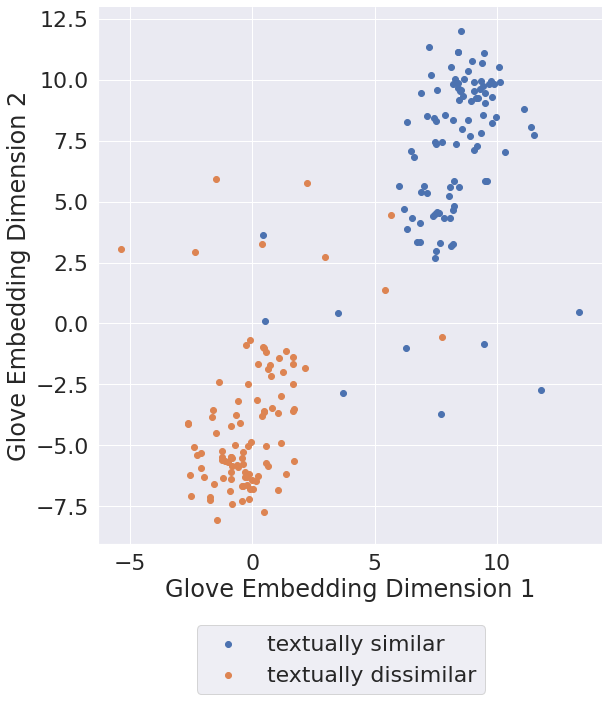

In [ ]:
sns.set(font_scale = 2.0)
# sns.set(fontsize=15)
sns.FacetGrid(complete_tsne_df, hue="Textual_Similarity", height=9).map(plt.scatter, 'Dim_1', 'Dim_2')
# plt.figsize(50, 50)
plt.legend(labels=['textually similar', 'textually dissimilar'],bbox_to_anchor=(0.79, -0.13))
# plt.title('Scatter Plot of Glove Embedding of Textually Similar Data')
plt.xlabel('Glove Embedding Dimension 1')
plt.ylabel('Glove Embedding Dimension 2')
# plt.legend()
plt.savefig('textually-similarity-based-tsne-Eclipse.jpg',bbox_inches = 'tight')
plt.show()

# **Mobile**

# Textually Similar

In [ ]:
df_sim1 = pd.read_csv("drive/MyDrive/Project 6308 + ICSME/Dataset Pre-processing_Siamese/Dataset for Siamese model /Mobile_siamese_sim_all_preprocessed.csv")
df_sim = df_sim1[df_sim1['is_similar'] > 0]
df_sim = df_sim.sample(n=100, random_state=1).reset_index(drop=True)
df_sim.loc[df_sim["is_similar"] == 1, "Textual_Similarity"] = "Textually Similar"
df_sim

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,232,created attachment screen shot at ...,do not include leanplum api keys in simulato...,1,Textually Similar
1,177,most colors will be themeable and thus need...,rather than individual ui items setting thei...,1,Textually Similar
2,200,created attachment screen shot at ...,see on master and x pre requisites ena...,1,Textually Similar
3,307,we are seeing multiple reports of this exce...,from github mobile fenix issues ...,1,Textually Similar
4,87,we should investigate what s the story for p...,currently the gv autocomplete api only supp...,1,Textually Similar
...,...,...,...,...,...
95,189,crash report stats mozilla org report ind...,crash report stats mozilla org report ind...,1,Textually Similar
96,282,geckoresult allow is sometimes created on ...,they are big footguns because it s very easy...,1,Textually Similar
97,236,filed by sgiesecke at mozilla com p...,filed by rgurzau at mozilla com par...,1,Textually Similar
98,246,i m not happy with how we now have three dif...,marketing has requested the following deep l...,1,Textually Similar


In [ ]:
MAX_TOKENS = 100
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 300
EMBEDDING_DIM = 100

In [ ]:
#Building a vocab and creating a word embedding of the descriptions

descr_vectorizer, descr_word_index = build_vocab(
  [df_sim.description1, df_sim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'the', 'to', 'system']


In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (100, 100)
Found 85 words, missed 13.


In [ ]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.03024   ,  0.44606   ,  0.43166   , ..., -0.79922998,
         0.80848998,  0.37378001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 100 points as TSNE takes a lot of time for 15K points
data_100 = descr_embedding_matrix
# labels_100 = df_dissim.is_similar

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=7000,metric='cosine')
# configuring the parameteres

tsne_data = model.fit_transform(data_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [ ]:
sim_label = df_sim["Textual_Similarity"]

In [ ]:
tsne_data = np.vstack((tsne_data.T, sim_label)).T
tsne_df_sim = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Textual_Similarity"))

In [ ]:
tsne_df_sim

,Dim_1,Dim_2,Textual_Similarity
0,-0.475479,-12.092031,Textually Similar
1,-5.51581,-6.734857,Textually Similar
2,-0.769743,3.865072,Textually Similar
3,0.533732,4.076686,Textually Similar
4,-1.167682,1.945129,Textually Similar
...,...,...,...
95,-0.132073,5.61717,Textually Similar
96,1.200584,4.612075,Textually Similar
97,-0.540666,3.120267,Textually Similar
98,7.016122,-4.61702,Textually Similar


# Textually Dissimilar

In [ ]:
df_dissim1 = pd.read_csv("drive/MyDrive/Project 6308 + ICSME/Dataset Pre-processing_Siamese/Dataset for Siamese model /Mobile_siamese_dissim_all_preprocessed.csv")
df_dissim = df_dissim1[df_dissim1['is_similar'] > 0]
df_dissim = df_dissim.sample(n=100, random_state=1).reset_index(drop=True)
df_dissim.loc[df_dissim["is_similar"] == 1, "Textual_Similarity"] = "Textually Dissimilar"
df_dissim

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,246,created attachment user age...,with night mode enabled the user will enjoy...,1,Textually Dissimilar
1,234,found users experiencing non stop startup ...,our fourth validation step looks like this ...,1,Textually Dissimilar
2,138,filed by apavel at mozilla com job id...,filed by ncsoregi at mozilla com job ...,1,Textually Dissimilar
3,252,user agent mozilla gecko firefox ...,created attachment nightly jpg i was ...,1,Textually Dissimilar
4,241,follow up to bug cgi id as a s...,this bug is for follow up work to bug ...,1,Textually Dissimilar
...,...,...,...,...,...
95,277,created attachment jpeg user ag...,created attachment walmart com on mobile ...,1,Textually Dissimilar
96,164,seen in mobile fenix issues and can be e...,created attachment log txt reference brow...,1,Textually Dissimilar
97,40,filed by abutkovits at mozilla com ...,filed by csabou at mozilla com pars...,1,Textually Dissimilar
98,197,created attachment screenshot this works ...,str go to a wikipedia article select so...,1,Textually Dissimilar


In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [df_dissim.description1, df_dissim.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'task', 'info', 'org']


In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (100, 100)
Found 89 words, missed 9.


In [ ]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.87711   ,  0.024024  ,  0.24731   , ..., -0.67763001,
         0.52288002,  0.37309   ],
       ...,
       [-0.46952999,  0.38431999,  0.54833001, ..., -0.68914002,
         0.45109999,  0.25125   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 100 points as TSNE takes a lot of time for 15K points
data_100 = descr_embedding_matrix
# labels_100 = df_dissim.is_similar

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=7000,metric='cosine')
# configuring the parameteres

tsne_data = model.fit_transform(data_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [ ]:
sim_label = df_dissim["Textual_Similarity"]

In [ ]:
tsne_data = np.vstack((tsne_data.T, sim_label)).T
tsne_df_dissim = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Textual_Similarity"))

Concatenating both the tsne tables for textually similar and dissimilar

In [ ]:
complete_tsne_df = pd.concat([tsne_df_sim, tsne_df_dissim], ignore_index=True)
complete_tsne_df

,Dim_1,Dim_2,Textual_Similarity
0,-0.475479,-12.092031,Textually Similar
1,-5.51581,-6.734857,Textually Similar
2,-0.769743,3.865072,Textually Similar
3,0.533732,4.076686,Textually Similar
4,-1.167682,1.945129,Textually Similar
...,...,...,...
195,-1.456085,-9.384459,Textually Dissimilar
196,1.171257,-8.763752,Textually Dissimilar
197,0.730214,-8.830351,Textually Dissimilar
198,5.996049,0.514666,Textually Dissimilar


Using seaborn to visualize it

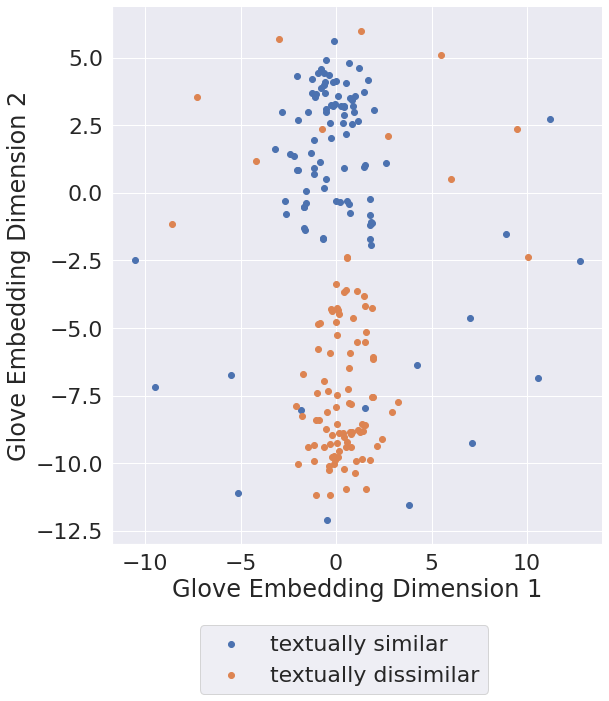

In [ ]:
sns.set(font_scale = 2.0)
# sns.set(fontsize=15)
sns.FacetGrid(complete_tsne_df, hue="Textual_Similarity", height=9).map(plt.scatter, 'Dim_1', 'Dim_2')
# plt.figsize(50, 50)
plt.legend(labels=['textually similar', 'textually dissimilar'],bbox_to_anchor=(0.79, -0.13))
# plt.title('Scatter Plot of Glove Embedding of Textually Similar Data')
plt.xlabel('Glove Embedding Dimension 1')
plt.ylabel('Glove Embedding Dimension 2')
# plt.legend()
plt.savefig('textually-similarity-based-tsne-Mobile.jpg',bbox_inches = 'tight')
plt.show()

# **FIREFOX**

# Textually Similar

In [ ]:
firefox_df_sim1 = pd.read_csv("drive/MyDrive/Project 6308 + ICSME/Dataset Pre-processing_Siamese/Dataset for Siamese model /Firefox_siamese_textually_similar_test_duplicates_preprocessed.csv")

In [ ]:
firefox_df_sim = firefox_df_sim1[firefox_df_sim1['is_similar'] > 0]

In [ ]:
firefox_df_sim = firefox_df_sim.drop(columns=["Unnamed: 0"])

In [ ]:
firefox_df_sim_100 = firefox_df_sim.sample(n=100)
firefox_df_sim_100

,description1,description2,is_similar
690,in the newest version of firefox on macos ...,user agent mozilla applewebkit ...,1
233,created attachment make default png affe...,the search bar in preferences currently has ...,1
681,user agent mozilla gecko firefox ...,created attachment correct result while b...,1
984,user agent mozilla gecko firefox ...,created attachment mediumdpi png user age...,1
991,created attachment screenshot png user ag...,created attachment screenshot demonstratin...,1
...,...,...,...
1379,created attachment screenshot of jsfiddle ...,this is needed to fix bug the idea is ...,1
1093,user agent mozilla gecko firefox ...,created attachment screencast str o...,1
370,created attachment screenshot for the issu...,affected versions nightly affected ...,1
928,created attachment screencast issue gif ...,created attachment screencast issue gif ...,1


In [ ]:
firefox_df_sim_100 = firefox_df_sim_100.reset_index(drop=True)
firefox_df_sim_100

,description1,description2,is_similar
0,in the newest version of firefox on macos ...,user agent mozilla applewebkit ...,1
1,created attachment make default png affe...,the search bar in preferences currently has ...,1
2,user agent mozilla gecko firefox ...,created attachment correct result while b...,1
3,user agent mozilla gecko firefox ...,created attachment mediumdpi png user age...,1
4,created attachment screenshot png user ag...,created attachment screenshot demonstratin...,1
...,...,...,...
95,created attachment screenshot of jsfiddle ...,this is needed to fix bug the idea is ...,1
96,user agent mozilla gecko firefox ...,created attachment screencast str o...,1
97,created attachment screenshot for the issu...,affected versions nightly affected ...,1
98,created attachment screencast issue gif ...,created attachment screencast issue gif ...,1


In [ ]:
firefox_df_sim_100['Textual Similarity'] = 'Textually Similar'

In [ ]:
firefox_df_sim_100

,description1,description2,is_similar,Textual Similarity
0,in the newest version of firefox on macos ...,user agent mozilla applewebkit ...,1,Textually Similar
1,created attachment make default png affe...,the search bar in preferences currently has ...,1,Textually Similar
2,user agent mozilla gecko firefox ...,created attachment correct result while b...,1,Textually Similar
3,user agent mozilla gecko firefox ...,created attachment mediumdpi png user age...,1,Textually Similar
4,created attachment screenshot png user ag...,created attachment screenshot demonstratin...,1,Textually Similar
...,...,...,...,...
95,created attachment screenshot of jsfiddle ...,this is needed to fix bug the idea is ...,1,Textually Similar
96,user agent mozilla gecko firefox ...,created attachment screencast str o...,1,Textually Similar
97,created attachment screenshot for the issu...,affected versions nightly affected ...,1,Textually Similar
98,created attachment screencast issue gif ...,created attachment screencast issue gif ...,1,Textually Similar


In [ ]:
MAX_TOKENS = 100
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 300
EMBEDDING_DIM = 100

Building a vocab and creating a word embedding of the descriptions

In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [firefox_df_sim_100.description1, firefox_df_sim_100.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'the', 'to', 'a']


In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (100, 100)
Found 96 words, missed 2.


In [ ]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.03024   ,  0.44606   ,  0.43166   , ..., -0.79922998,
         0.80848998,  0.37378001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Using TSNE to reduce the dimensionality

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 100 points as TSNE takes a lot of time for 15K points
data_100 = descr_embedding_matrix
# labels_100 = df_dissim.is_similar

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=7000,metric='cosine')
# configuring the parameteres

tsne_data = model.fit_transform(data_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [ ]:
firefox_sim_label = firefox_df_sim_100["Textual Similarity"]

In [ ]:
tsne_data = np.vstack((tsne_data.T, firefox_sim_label)).T
tsne_df_sim_firefox = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Textual_Similarity"))

In [ ]:
tsne_df_sim_firefox

,Dim_1,Dim_2,Textual_Similarity
0,-8.758291,-12.752036,Textually Similar
1,-16.360613,8.573765,Textually Similar
2,3.08654,4.618324,Textually Similar
3,2.204779,2.808014,Textually Similar
4,3.817689,4.744459,Textually Similar
...,...,...,...
95,-0.598129,3.869098,Textually Similar
96,4.267524,3.996874,Textually Similar
97,3.949637,4.068681,Textually Similar
98,-16.890369,0.37041,Textually Similar


# Textually Dissimilar

In [ ]:
firefox_df_dissim1 = pd.read_csv("drive/MyDrive/Project 6308 + ICSME/Dataset Pre-processing_Siamese/Dataset for Siamese model /Firefox_siamese_textually_dissimilar_test_duplicates_preprocessed.csv")
firefox_df_dissim1

,Unnamed: 0,description1,description2,is_similar
0,0,user agent mozilla gecko firefox ...,created attachment screen shot at ...,1
1,1,open the general tab in preferences scrol...,according to the design spec we would li...,1
2,2,hook up the sidebar switcher to the history ...,user agent mozilla gecko firefox ...,0
3,3,created attachment firefox profi...,created attachment screen capture wmv ste...,1
4,4,filed by wkocher at mozilla com job i...,central as beta simulation jobs repo tr...,0
...,...,...,...,...
1452,1495,created attachment troubleshooting info an...,user agent mozilla gecko firefox ...,1
1453,1496,bug was originally filed for favicons fal...,in each new window that i open the bookmark...,0
1454,1497,created attachment image png the last thi...,this bug was filed from the socorro interfac...,0
1455,1498,restylesearches is brittle to unexpected dif...,bug added the browser urlbar restylesearc...,1


In [ ]:
firefox_df_dissim = firefox_df_dissim1[firefox_df_dissim1['is_similar'] > 0]

In [ ]:
firefox_df_dissim = firefox_df_dissim.drop(columns = ["Unnamed: 0"])
firefox_df_dissim

,description1,description2,is_similar
0,user agent mozilla gecko firefox ...,created attachment screen shot at ...,1
1,open the general tab in preferences scrol...,according to the design spec we would li...,1
3,created attachment firefox profi...,created attachment screen capture wmv ste...,1
9,user agent mozilla gecko firefox ...,str go to options select search t...,1
10,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,1
...,...,...,...
1447,str open a private browsing mode window ...,the current behavior for block autoplay in p...,1
1448,filed by philringnalda at gmail com j...,filed by tomcat at mozilla com job id...,1
1449,report from bryant mao i found that if i cl...,str click the fox head on new tab page ...,1
1452,created attachment troubleshooting info an...,user agent mozilla gecko firefox ...,1


In [ ]:
firefox_df_dissim_100 = firefox_df_dissim.sample(n=100)
firefox_df_dissim_100

,description1,description2,is_similar
370,user agent mozilla gecko firefox ...,users seeing regular sync failures due to se...,1
1352,created attachment firfox installer issue ...,created attachment uninstall failed log ...,1
736,i currently can t add a bookmark if the loca...,user agent mozilla gecko firefox ...,1
208,i had filed bug when working on bug sin...,i had filed bug when working on bug sin...,1
1281,this bug was filed from the socorro interfac...,release note request why is this notable ...,1
...,...,...,...
731,filed by btara at mozilla com parse...,filed by malexandru at mozilla com ...,1
1207,setting extensions pocket enabled preferen...,created attachment pocket menu items png ...,1
180,created attachment recommendation label s...,we re only launching the experiment in ltr l...,1
285,should add a button in single search tour in...,should add the single search location tour i...,1


In [ ]:
firefox_df_dissim_100['Textual Similarity'] = 'Textually Dissimilar'

In [ ]:
firefox_df_dissim_100

,description1,description2,is_similar,Textual Similarity
370,user agent mozilla gecko firefox ...,users seeing regular sync failures due to se...,1,Textually Dissimilar
1352,created attachment firfox installer issue ...,created attachment uninstall failed log ...,1,Textually Dissimilar
736,i currently can t add a bookmark if the loca...,user agent mozilla gecko firefox ...,1,Textually Dissimilar
208,i had filed bug when working on bug sin...,i had filed bug when working on bug sin...,1,Textually Dissimilar
1281,this bug was filed from the socorro interfac...,release note request why is this notable ...,1,Textually Dissimilar
...,...,...,...,...
731,filed by btara at mozilla com parse...,filed by malexandru at mozilla com ...,1,Textually Dissimilar
1207,setting extensions pocket enabled preferen...,created attachment pocket menu items png ...,1,Textually Dissimilar
180,created attachment recommendation label s...,we re only launching the experiment in ltr l...,1,Textually Dissimilar
285,should add a button in single search tour in...,should add the single search location tour i...,1,Textually Dissimilar


Building a vocab and creating word embedding of the description

In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [firefox_df_dissim_100.description1, firefox_df_dissim_100.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'info', 'task', 'browser']


In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (100, 100)
Found 95 words, missed 3.


In [ ]:
descr_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.81967002, -0.14202   ,  0.64740998, ..., -0.55650997,
         0.34254   ,  0.29034999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Using TSNE to reduce the dimensionality

In [ ]:
from sklearn.manifold import TSNE

# Picking the top 100 points as TSNE takes a lot of time for 15K points
data_100 = descr_embedding_matrix
# labels_100 = df_dissim.is_similar

model = TSNE(n_components=2, random_state=0,perplexity = 40,n_iter=7000,metric='cosine')
# configuring the parameteres

tsne_data = model.fit_transform(data_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [ ]:
firefox_dissim_label = firefox_df_dissim_100["Textual Similarity"]

In [ ]:
tsne_data = np.vstack((tsne_data.T, firefox_dissim_label)).T
tsne_df_dissim_firefox = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","Textual_Similarity"))

Concatenating both the tsne tables for textually similar and dissimilar

In [ ]:
complete_tsne_df_firefox = pd.concat([tsne_df_sim_firefox, tsne_df_dissim_firefox], ignore_index=True)
complete_tsne_df_firefox

,Dim_1,Dim_2,Textual_Similarity
0,-8.758291,-12.752036,Textually Similar
1,-16.360613,8.573765,Textually Similar
2,3.08654,4.618324,Textually Similar
3,2.204779,2.808014,Textually Similar
4,3.817689,4.744459,Textually Similar
...,...,...,...
195,1.929523,-3.589816,Textually Dissimilar
196,0.773016,-4.281426,Textually Dissimilar
197,0.124994,5.3759,Textually Dissimilar
198,-1.994868,3.225476,Textually Dissimilar


Using seaborn to visualize it

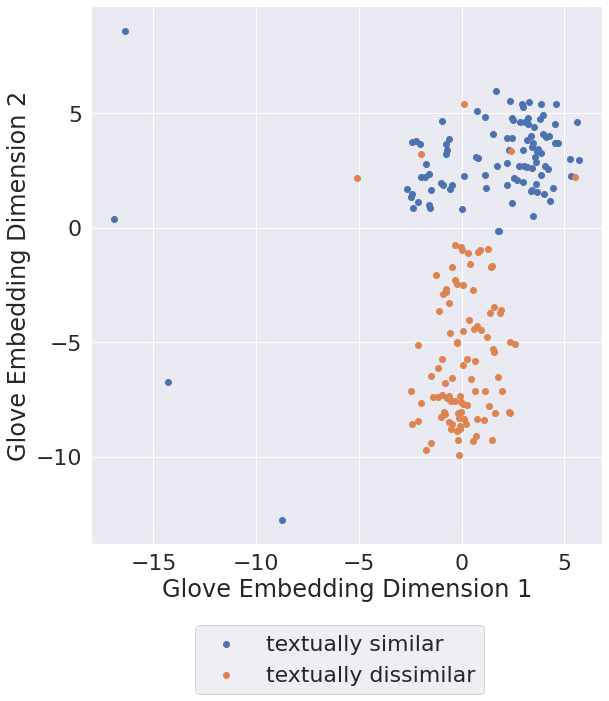

In [ ]:
sns.set(font_scale = 2.0)
# sns.set(fontsize=15)
sns.FacetGrid(complete_tsne_df_firefox, hue="Textual_Similarity", height=9).map(plt.scatter, 'Dim_1', 'Dim_2')
# plt.figsize(50, 50)
plt.legend(labels=['textually similar', 'textually dissimilar'],bbox_to_anchor=(0.79, -0.13))
# plt.title('Scatter Plot of Glove Embedding of Textually Similar Data')
plt.xlabel('Glove Embedding Dimension 1')
plt.ylabel('Glove Embedding Dimension 2')
# plt.legend()
plt.savefig('textually-similarity-based-tsne-firefox.jpg',bbox_inches = 'tight')
plt.show()

In [ ]:
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [ ]:
import matplotlib.patheffects as PathEffects
def plot_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    print(num_classes)
    palette = np.array(sns.color_palette("hls", num_classes))
    #print(palette)
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    #sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=df['label'], cmap=plt.cm.get_cmap('Paired'))
    sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
complete_tsne_df_firefox['label'] = ['1' if x  == 'Textually Similar' else '0' for x in complete_tsne_df_firefox['Textual_Similarity']]
complete_tsne_df_firefox

,Dim_1,Dim_2,Textual_Similarity,label
0,-8.758291,-12.752036,Textually Similar,1
1,-16.360613,8.573765,Textually Similar,1
2,3.08654,4.618324,Textually Similar,1
3,2.204779,2.808014,Textually Similar,1
4,3.817689,4.744459,Textually Similar,1
...,...,...,...,...
195,1.929523,-3.589816,Textually Dissimilar,0
196,0.773016,-4.281426,Textually Dissimilar,0
197,0.124994,5.3759,Textually Dissimilar,0
198,-1.994868,3.225476,Textually Dissimilar,0
